In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr
from pathlib import Path
import h5py
import os, sys
import matplotlib.pyplot as plt
sys.path.insert(1, '/home/sbidadi/atom/sbidadi')
from windtools.windtools.amrwind.post_processing  import ABLStatistics, Sampling, addDatetime

In [2]:
from windtools.windtools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum
from windtools.windtools.amrwind.post_processing  import ABLStatistics, Sampling, addDatetime

sys.path.append(os.path.abspath('/home/rthedin/repos/mmctools'))
from mmctools.helper_functions import covariance, calc_wind, calc_spectra, fit_powerlaw

sys.path.append(os.path.abspath('/home/rthedin/utilities/'))
from helper import *

In [3]:
dir0 = Path('/scratch/sbidadi/ai4wind/windai/simulations/maine_sweep/wspd10_ai/post_processing/')
f0 = Path(dir0, 'slices00000.nc')

In [4]:
with Dataset(f0, "r") as template:
    print("template.cmptypes", template.cmptypes)
    print("template.data_model", template.data_model)
    print("template.dimensions", template.dimensions)
    print("template.disk_format", template.disk_format)
    print("template.enumtypes", template.enumtypes)
    print("template.file_format", template.file_format)
    print("template.groups", template.groups)
    print("template.keepweakref", template.keepweakref)
    print("template.name", template.name)
    print("template.parent", template.parent)
    print("template.path", template.path)
    print("template.variables", template.variables)
    print("template.vltypes", template.vltypes)

template.cmptypes {}
template.data_model NETCDF4
template.dimensions {'num_time_steps': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'num_time_steps', size = 596, 'ndim': <class 'netCDF4._netCDF4.Dimension'>: name = 'ndim', size = 3}
template.disk_format HDF5
template.enumtypes {}
template.file_format NETCDF4
template.groups {'box1': <class 'netCDF4._netCDF4.Group'>
group /box1:
    sampling_type: PlaneSampler
    ijk_dims: [336 144   5]
    origin: [ 1.25e-10  1.25e-10 -1.80e+02]
    axis1: [1.25000000e-10 8.40000000e+02 1.24998678e-10]
    axis2: [1.25e-10 1.25e-10 3.60e+02]
    offset_vector: [1. 0. 0.]
    offsets: [100. 200. 300. 400. 500.]
    dimensions(sizes): num_points(241920)
    variables(dimensions): float64 coordinates(num_points, ndim), float64 velocityx(num_time_steps, num_points), float64 velocityy(num_time_steps, num_points), float64 velocityz(num_time_steps, num_points)
    groups: }
template.keepweakref False
template.name /
template.parent None
template

In [5]:
### Grab raw data from .nc file
with h5py.File(f0) as f:
    # Time
    time0 = f['time'][:]
    
    # xz-plane
    yz_coords_raw = f['box1']['coordinates'][:]

print(np.shape(time0))
print(np.shape(yz_coords_raw))

### Reformat xz plane
yz_xcoords = np.sort(np.unique(np.round(yz_coords_raw[:,0],6)))
yz_ycoords = np.sort(np.unique(np.round(yz_coords_raw[:,1],6)))
yz_zcoords = np.sort(np.unique(np.round(yz_coords_raw[:,2],6)))

yz_coords = {'time':time0, 'x': yz_xcoords, 'y': yz_ycoords, 'z': yz_zcoords}
ds_yz = xr.Dataset(yz_coords)

for var in ['velocityz', 'velocityy', 'velocityx']:
    with h5py.File(f0, 'r') as f:
        curr_arr = f['box1'][var][:]
        arr_reshaped = curr_arr.reshape((len(time0), len(yz_xcoords), len(yz_ycoords), len(yz_zcoords)))
        ds_yz[var] = (('time', 'x', 'y', 'z'), arr_reshaped)

(596,)
(241920, 3)


In [6]:
ds_yz = ds_yz.rename({'velocityx': 'u', 'velocityy': 'v', 'velocityz': 'w'})

In [7]:
ds_yz

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 596, x: 5, y: 336, z: 144)
Coordinates:
  * time     (time) float64 5kB 0.0 0.1 0.2 0.3 0.4 ... 59.1 59.2 59.3 59.4 59.5
  * x        (x) float64 40B 100.0 200.0 300.0 400.0 500.0
  * y        (y) float64 3kB 0.0 2.507 5.015 7.522 ... 832.5 835.0 837.5 840.0
  * z        (z) float64 1kB -180.0 -177.5 -175.0 -172.4 ... 175.0 177.5 180.0
Data variables:
    w        (time, x, y, z) float64 1GB 1.397e-31 1.402e-31 ... 0.000373
    v        (time, x, y, z) float64 1GB 0.0 0.0 0.0 ... 0.02894 0.0292 0.0296
    u        (time, x, y, z) float64 1GB 5.638e-20 5.638e-20 ... 6.386 6.386

In [8]:
######################################### umean vs. z (at x = 100m) ###################################
istart = 300
iend = 590
ix = 0

Ny = ds_yz.y.shape[0]
Nz = ds_yz.z.shape[0]

utot = []
for i in range(istart, iend, 1):
    tsel = i
    snapshot = ds_yz.isel(time=tsel,x=ix)
    time = float(snapshot.time)
    utot.append(snapshot['u'].values.ravel())
    
umean = np.mean(utot, axis=0)

# utot = []
# for i in range(300, 590, 1):
#     tsel = i
#     snapshot = ds_yz.isel(time=tsel,x=0)
#     time = float(snapshot.time)
#     utot.append(snapshot['v'].values.ravel())
# vmean = np.mean(utot, axis=0)
# print(vmean)
# print(np.min(vmean), np.max(vmean))

# utot = []
# for i in range(300, 590, 1):
#     tsel = i
#     snapshot = ds_yz.isel(time=tsel,x=0)
#     time = float(snapshot.time)
#     utot.append(snapshot['w'].values.ravel())
# wmean = np.mean(utot, axis=0)
# print(umean)
# print(np.min(wmean), np.max(wmean))

1
(336, 144)
[[1.38898175e-05 1.41074661e-05 1.42605899e-05 ... 1.32613837e-05
  1.36079453e-05 1.38898175e-05]
 [1.40342273e-05 1.42523575e-05 1.44057276e-05 ... 1.34042997e-05
  1.37517279e-05 1.40342273e-05]
 [1.44553012e-05 1.46747492e-05 1.48288594e-05 ... 1.38209565e-05
  1.41708839e-05 1.44553012e-05]
 ...
 [1.62713343e-02 1.58765328e-02 1.54726290e-02 ... 1.70346862e-02
  1.66537680e-02 1.62713343e-02]
 [4.49336731e-03 3.98726001e-03 3.48658711e-03 ... 5.50834982e-03
  5.00079744e-03 4.49336731e-03]
 [9.86095921e-03 9.35753393e-03 8.86156071e-03 ... 1.08692367e-02
  1.03647036e-02 9.86095922e-03]]


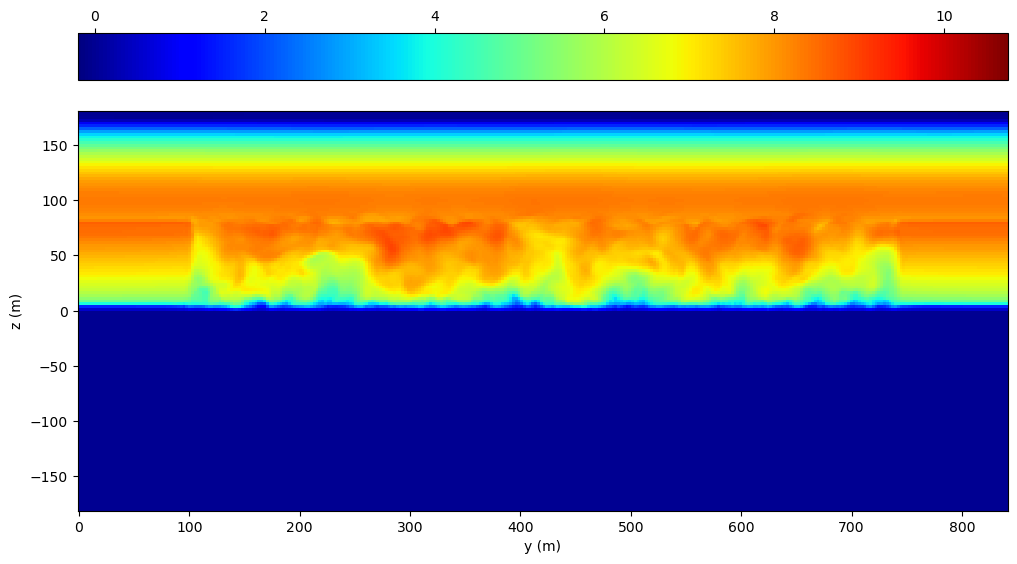

In [9]:
zz,yy = np.meshgrid(ds_yz.z, ds_yz.y, indexing='ij')
fig, ax = plt.subplots(1,1,figsize=(12,8))

ax.set_xlabel("y (m)")
ax.set_ylabel("z (m)")

cmap = plt.colormaps['jet']

itime = 1
print(itime)
if itime == 0:
    cm = ax.pcolormesh(zz, yy, snapshot2['u'].T)
    fig.colorbar(cm, ax=ax, label='u [m/s]')
    ax.set_aspect('equal')
else:
    cm = ax.pcolormesh(yy,zz,snapshot['u'].T, cmap=cmap)
    cm.set_array(umean)
    
fig.colorbar(cm, ax=ax,location="top")
fig.gca().set_aspect('equal')

print(snapshot['u'].shape)
udata_mesh = cm.get_array()
udata_mesh_rs = udata_mesh.reshape(Nz, Ny)
print(udata_mesh_rs)

<xarray.DataArray 'y' ()> Size: 8B
array(175.522388)
Coordinates:
    y        float64 8B 175.5
<xarray.DataArray 'y' ()> Size: 8B
array(626.865672)
Coordinates:
    y        float64 8B 626.9
<xarray.DataArray 'z' ()> Size: 8B
array(1.258741)
Coordinates:
    z        float64 8B 1.259
<xarray.DataArray 'z' ()> Size: 8B
array(81.818182)
Coordinates:
    z        float64 8B 81.82
6.223058993108818


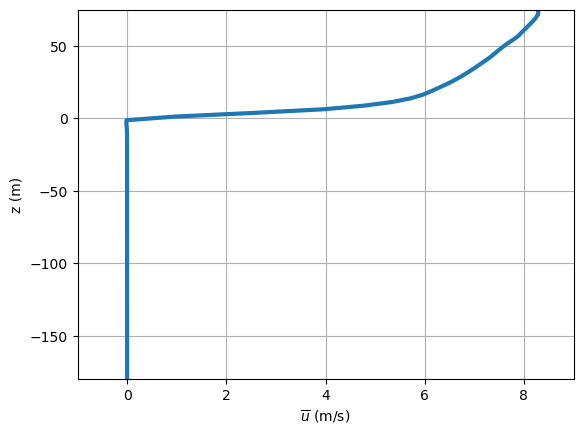

In [39]:
ystart_index = 70
yend_index = 250

print(ds_yz.y[70])
print(ds_yz.y[250])

zstart_index = 72
print(ds_yz.z[72])

zend_index = 104
print(ds_yz.z[104])

plt.figure()
plt.grid()
umean_z = np.mean(udata_mesh_rs[:,ystart_index:yend_index],axis=1)
plt.plot(umean_z,ds_yz['z'],linewidth=3)
plt.xlabel(r'$\overline{u}$ (m/s)')
#plt.hlines(y=80, xmin=-1.0, xmax=10.0, color='k', alpha=0.7, linestyle='--',linewidth=3)
plt.ylabel('z (m)')
plt.xlim(-1.0,9.0)
plt.ylim(-180.0,75.0)
print(np.mean(umean_z[zstart_index:]))

In [11]:
####################################### Turbulent Intensity ##################################

In [ ]:
# snapshot2 = ds_yz.isel(time=500,x=0)
# u_at_one_time = snapshot2['u'].values.ravel()
# print(u_at_one_time.size)

# zz,yy = np.meshgrid(ds_yz.z, ds_yz.y, indexing='ij')
# fig, ax = plt.subplots(1,1,figsize=(12,8))

# ax.set_xlabel("y (m)")
# ax.set_ylabel("z (m)")
# cmap = plt.colormaps['jet']

# itime = 1
# print(itime)
# if itime == 0:
#     cm = ax.pcolormesh(zz, yy, snapshot2['u'].T)
# #    ax.plt()
#     fig.colorbar(cm, ax=ax, label='u [m/s]')
#     ax.set_aspect('equal')
# else:
#     cm = ax.pcolormesh(yy,zz,snapshot['u'].T, cmap=cmap)
#     cm.set_array(u_at_one_time)
    
# fig.colorbar(cm, ax=ax,location="top")
# fig.gca().set_aspect('equal')

# udata_one_time_mesh = cm.get_array()
# print("hello")
# print(udata_one_time_mesh.shape)

# udata_one_time_mesh_rs = udata_one_time_mesh.reshape(144, 336)
# print(udata_one_time_mesh_rs.shape)

# plt.figure()
# plt.grid()
# #(z,y)
# print(np.shape(udata_one_time_mesh_rs))
# udata_one_time_z = np.mean(udata_one_time_mesh_rs[:,70:250],axis=1)
# plt.scatter(udata_one_time_z,ds_yz['z'])
# plt.xlabel('umean (m/s)')
# plt.ylabel('z (m)')

# # finding TI at each grid point
# mean_of_sq_up = 0.0
# sq_up_at_one_time = np.square(udata_one_time_mesh_rs - udata_mesh_rs)
# mean_of_sq_up = mean_of_sq_up + sq_up_at_one_time
# mean_of_sq_up = mean_of_sq_up / 1.0

# TI = (np.sqrt(mean_of_sq_up)/np.mean(umean_z[72:]))*100.0
# print(TI)

# # Spatially averaged TI:
# TI_mean = np.mean(TI[72:104,70:250])
# print(TI_mean)

10.662689550046927


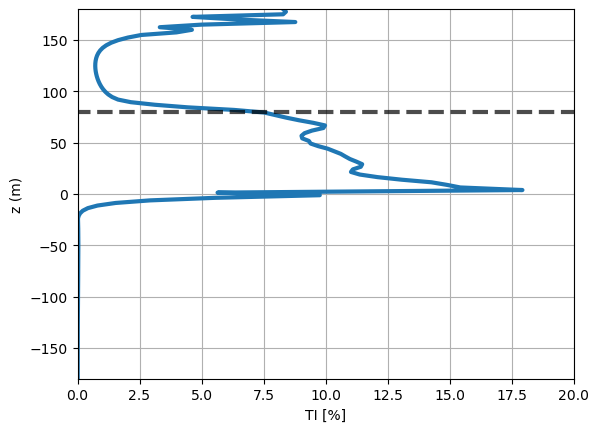

In [35]:
mean_of_sq_up = 0.0

for i in range(istart, iend, 1):
    tsel = i
    snapshot = ds_yz.isel(time=tsel,x=ix)    
    time = float(snapshot.time)

    u_at_one_time = snapshot['u'].values.ravel()
    udata_one_time_rs = u_at_one_time.reshape(Nz, Ny)
    
    sq_up_at_one_time = np.square(udata_one_time_rs - udata_mesh_rs)
    mean_of_sq_up = mean_of_sq_up + sq_up_at_one_time

mean_of_sq_up = mean_of_sq_up / (iend-istart)
TI = (np.sqrt(mean_of_sq_up)/np.mean(umean_z[zstart_index:]))*100.0

TImean_z = np.mean(TI[:,ystart_index:yend_index],axis=1)
plt.figure()
plt.grid()
plt.plot(TImean_z,ds_yz['z'],linewidth=3)
plt.xlabel('TI [%]')
plt.hlines(y=80, xmin=-1.0, xmax=20.0, color='k', alpha=0.7, linestyle='--',linewidth=3)
plt.ylabel('z (m)')
plt.xlim(0.0,20.0)
plt.ylim(-180.0,180.0)

# Spatially averaged TI:
TI_mean = np.mean(TI[zstart_index:zend_index,ystart_index:yend_index])
print(TI_mean)

In [ ]:
plt.figure()
plt.grid()
plt.scatter(uvar_mean_z,ds_yz['z'])
plt.xlabel('TI')
plt.ylabel('z (m)')

In [ ]:
fstart = 0.005
fend = 0.4005
fstep = 0.005
freq = np.arange(fstart, fend, fstep)

PSDx = ds['PSDx'][:]
PSDy = ds['PSDy'][:]
PSDz = ds['PSDz'][:]

fig, axs = plt.subplots(3, 1, figsize=(20, 8))  # 3 rows, 1 column

for i in range(len(PSDx)):

    axs[0].plot(freq, PSDx[i,:])
    axs[0].set_xlabel(r'frequency (Hz)')
    axs[0].set_ylabel('$PSD_x (N^2/Hz)$')

    axs[1].plot(freq, PSDy[i,:])
    axs[1].set_xlabel(r'frequency (Hz)')
    axs[1].set_ylabel('$PSD_y (N^2/Hz)$')

    axs[2].plot(freq, PSDz[i,:])
    axs[2].set_xlabel(r'frequency (Hz)')
    axs[2].set_ylabel('$PSD_z (N^2/Hz)$')

plt.tight_layout()
plt.show()